In [1]:
import os
import torch
import mlflow
import gc
import time

from MED.modeling.modeling_utils import train_single_epoch_ES, validate_single_epoch_ES, \
      retrieve_results_mlflow_ES, create_summary_df, define_model_objects
from MED.dataset.dataset_utils import retrieve_dataloaders_window, compute_window_size_stride
from MED.visualization.utils import plot_results_LOSO, plot_cm

In [2]:
#def main(): #Main loop for training.
cuda = False
if cuda:
    torch.cuda.empty_cache() # Clear cache
    
else:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    torch.mps.empty_cache()

settings = ['LOSO']#, 'LOUO']
tasks = ['All', 'Suturing','Knot_Tying','Needle_Passing']
out1 = ['Bout','Cout','Dout','Eout','Fout','Gout','Hout','Iout']
out2 = ['1out', '2Out', '3out','4out','5out']

exp_kwargs = {
    'error_type': "all_errors",
    'dataset_type': "window", #'window' or 'frame' 
    'save_local': False,
    'pos_weight': False, #
    'use_COG_video': True,
    'n_epochs': 15,
    'batch_size': 512,
    'frequency': 5,
    'lr': 5e-4,
    'lr_scheduler': True, 
    'weight_decay': 1e-3,
    'num_layers': 3,
    'hidden_size': 128,
    'model_name': 'SimpleLSTM', #SimpleLSTM, SimpleCNN, Siamese_CNN, Siamese_LSTM 
    'siamese': False,
    'n_comparisons': 20,
    'n_pairs': 20000,
    'video_dims': 32, #32 default
    'loss_or_f1': 'f1',  #'loss' or 'f1' to determine the metric for validation
    'data_type': 'multimodal', #'multimodal' or 'video' or 'kinematics'
    'delete_ND': True,
    'compute_from_str': False,
    'return_train_preds': True,
    'out_features': 6
}

window_size, stride = compute_window_size_stride(exp_kwargs['frequency'])

best_model = None
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

#Set up folders to save results and images
results_folder = f"results/{exp_kwargs['data_type']}_error_specific/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/"
image_folder = f"images/{exp_kwargs['data_type']}_error_specific/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/" 

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if not os.path.exists(image_folder):
    os.makedirs(image_folder)

#Define in_features
in_features_dict = {
    'multimodal': exp_kwargs['video_dims'] + 26,
    'video': exp_kwargs['video_dims'],
    'kinematics': 26
}

Loading data for LOSO with trial 1out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3171
Number of testing windows: 1074
Class distribution for LOSO with trial 1out: [2.2020833492279053, 4.8045454025268555, 3.245649814605713, 18.54385757446289, 20.725489298502605, 21.571426391601562]
Class distribution for test set LOSO with trial 1out: [3.388012647628784, 4.339393615722656, 2.3708608150482178, 15.234039306640625, 47.7333017985026, 9.298700332641602]
Number of parameters to optimize: 1599590


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([865, 561, 495, 485, 376, 389]))
Epoch 1/15, F1: 0.2269,  Accuracy: 0.3573, Loss: 1.6816


Test: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


New best F1 score: 0.16750805497082055 at epoch 1, with binary F1: 0.811844540407156.


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1365,  493, 1067,   59,   69,  118]))


Test: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


New best F1 score: 0.2177732011111274 at epoch 2, with binary F1: 0.7695560253699789.


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1439,  334, 1339,   30,   21,    8]))


100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1469,  321, 1358,   13,    4,    6]))


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1458,  324, 1380,    4,    3,    2]))


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 4, 5]), array([1446,  287, 1436,    1,    1]))
Epoch 6/15, F1: 0.3455,  Accuracy: 0.7644, Loss: 0.6776


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2]), array([1456,  320, 1395]))


100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2]), array([1444,  347, 1380]))


100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2]), array([1445,  256, 1470]))


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 4]), array([1443,  214, 1513,    1]))


100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1461,  225, 1483,    2]))
Epoch 11/15, F1: 0.3407,  Accuracy: 0.7698, Loss: 0.6384


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1479,  250, 1439,    1,    1,    1]))


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1472,  271, 1427,    1]))


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2]), array([1457,  314, 1400]))


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1440,  440,  977,  114,  102,   98]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1455,  323, 1392,    1]))
Epoch 15/15, F1: 0.3537,  Accuracy: 0.7726, Loss: 0.6211


Test: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Inference rate: 0.8969 ms per window.


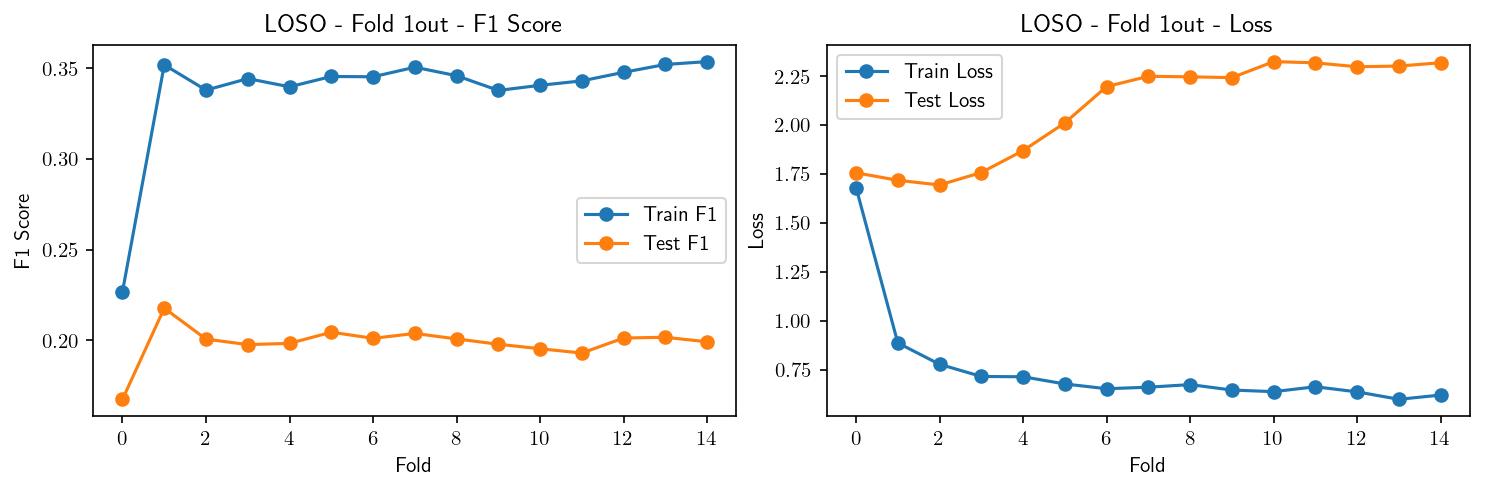

Loading data for LOSO with trial 2Out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3469
Number of testing windows: 776
Class distribution for LOSO with trial 2Out: [2.379286766052246, 4.543549537658691, 3.0590827465057373, 18.067705790201824, 25.69629414876302, 15.417775472005209]
Class distribution for test set LOSO with trial 2Out: [2.5953176021575928, 5.388888676961263, 2.621621608734131, 15.676762898763021, 19.160486857096355, 20.69332504272461]
Number of parameters to optimize: 1599590


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([758, 674, 615, 575, 407, 440]))
Epoch 1/15, F1: 0.2201,  Accuracy: 0.3229, Loss: 1.7930


Test: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


New best F1 score: 0.11623406843302131 at epoch 1, with binary F1: 0.7524752475247525.


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1388,  513, 1284,   91,  113,   80]))


Test: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


New best F1 score: 0.1691359666420276 at epoch 2, with binary F1: 0.5387453874538746.


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1436,  348, 1638,   22,   16,    9]))


Test: 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


New best F1 score: 0.17827173975673213 at epoch 3, with binary F1: 0.5204081632653061.


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1477,  354, 1631,    5,    1,    1]))


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1434,  326, 1697,    7,    2,    3]))


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 4, 5]), array([1462,  217, 1787,    1,    2]))
Epoch 6/15, F1: 0.3153,  Accuracy: 0.7293, Loss: 0.7342


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1482,  298, 1687,    2]))


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1469,  331, 1666,    1,    2]))


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1469,  292, 1706,    1,    1]))


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 4, 5]), array([1492,  275, 1699,    1,    2]))


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1476,  330, 1659,    1,    1,    2]))
Epoch 11/15, F1: 0.3379,  Accuracy: 0.7446, Loss: 0.6724


100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 5]), array([1464,  346, 1655,    4]))


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 5]), array([1466,  337, 1665,    1]))


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 5]), array([1460,  379, 1629,    1]))


100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1458,  509, 1134,  128,   90,  150]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1474,  374, 1618,    1,    2]))
Epoch 15/15, F1: 0.3505,  Accuracy: 0.7541, Loss: 0.6608


Test: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Inference rate: 0.8781 ms per window.


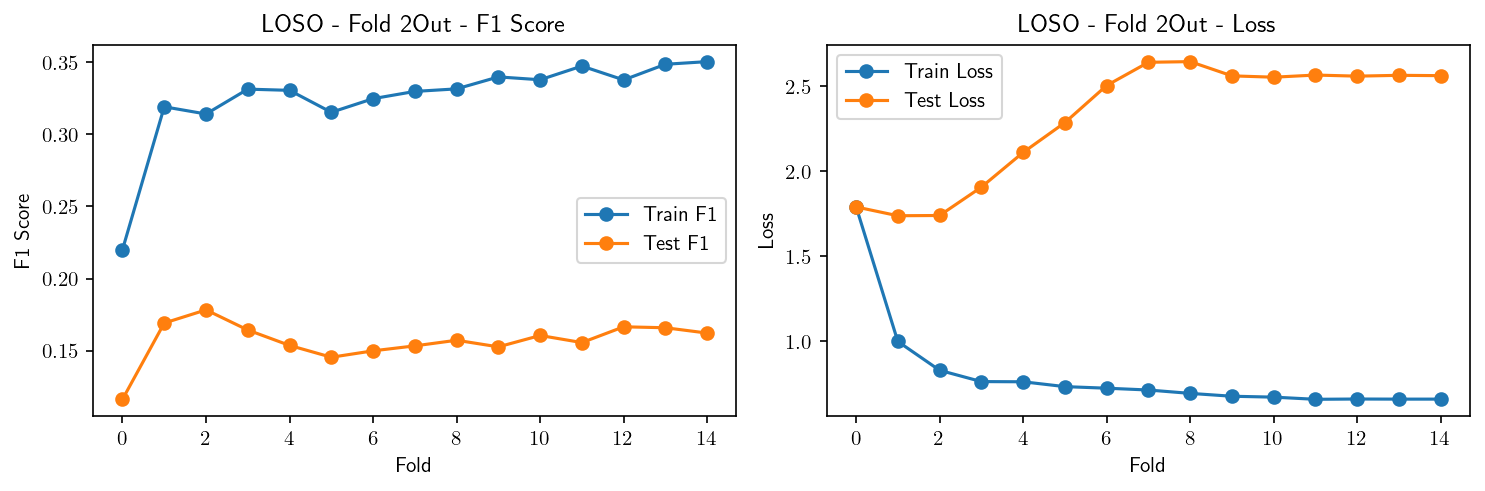

Loading data for LOSO with trial 3out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3360
Number of testing windows: 885
Class distribution for LOSO with trial 3out: [2.4561402797698975, 4.534413019816081, 2.914137125015259, 18.064515431722004, 29.090906778971355, 15.555553436279297]
Class distribution for test set LOSO with trial 3out: [2.27506422996521, 5.315314928690593, 3.194945812225342, 15.945940653483072, 14.749996185302734, 19.03225326538086]
Number of parameters to optimize: 1599590


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([763, 623, 565, 559, 403, 447]))
Epoch 1/15, F1: 0.2213,  Accuracy: 0.3205, Loss: 1.8025


Test: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


New best F1 score: 0.10085146696439824 at epoch 1, with binary F1: 0.7238095238095238.


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1234,  641,  977,  192,  156,  160]))


Test: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


New best F1 score: 0.19201249926898045 at epoch 2, with binary F1: 0.6653919694072657.


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1390,  312, 1569,   46,   28,   15]))


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1407,  399, 1532,   18,    4]))


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1423,  403, 1508,   16,    1,    9]))


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1349,  267, 1735,    3,    2,    4]))
Epoch 6/15, F1: 0.3423,  Accuracy: 0.7473, Loss: 0.7140


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1342,  226, 1790,    2]))


Test: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


New best F1 score: 0.2036578419609559 at epoch 7, with binary F1: 0.6640079760717846.


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1377,  334, 1646,    3]))


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1391,  354, 1612,    3]))


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4]), array([1426,  427, 1504,    2,    1]))


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1414,  448, 1496,    1,    1]))
Epoch 11/15, F1: 0.3615,  Accuracy: 0.7568, Loss: 0.6583


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1392,  430, 1531,    3,    4]))


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1373,  404, 1579,    2,    2]))


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1377,  391, 1587,    2,    3]))


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1368,  494, 1153,  124,   77,  144]))
Unique preds in train_all_preds: (array([0, 1, 2, 5]), array([1376,  402, 1577,    5]))
Epoch 15/15, F1: 0.3718,  Accuracy: 0.7738, Loss: 0.6152


Test: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Inference rate: 0.9828 ms per window.


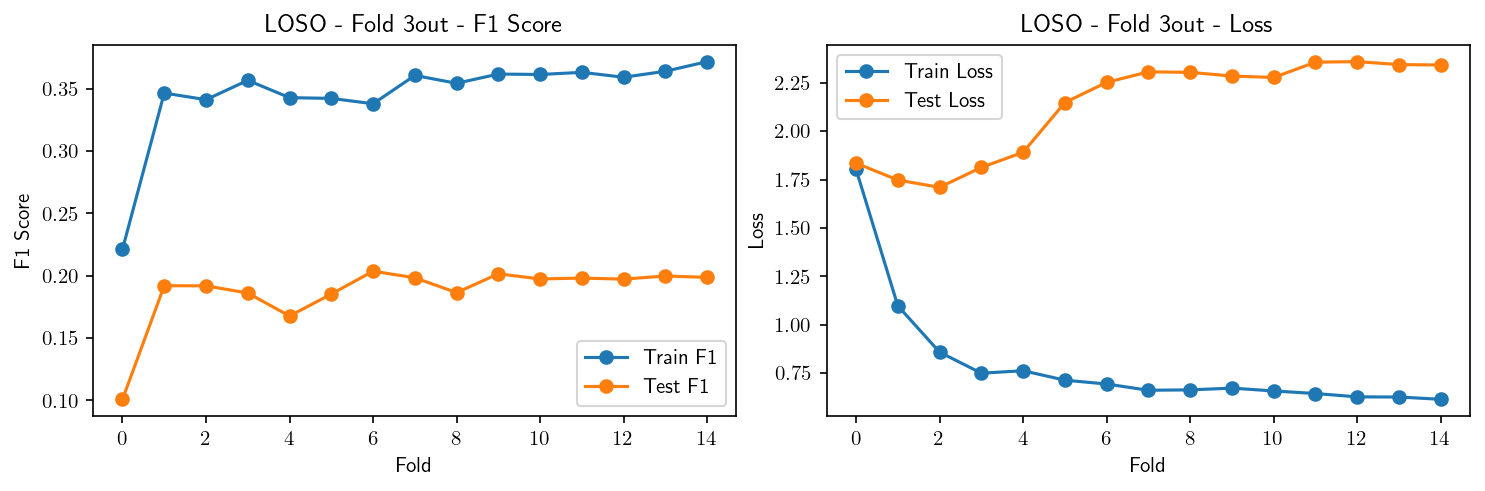

Loading data for LOSO with trial 4out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3375
Number of testing windows: 870
Class distribution for LOSO with trial 4out: [2.526197671890259, 4.955946922302246, 2.817195177078247, 15.734264373779297, 22.9591801961263, 15.410957336425781]
Class distribution for test set LOSO with trial 4out: [2.0665082931518555, 3.841059366861979, 3.749999523162842, 32.222206115722656, 30.52630106608073, 19.999993642171223]
Number of parameters to optimize: 1599590


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([857, 617, 537, 528, 425, 411]))
Epoch 1/15, F1: 0.2246,  Accuracy: 0.3277, Loss: 1.8029


Test: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


New best F1 score: 0.15125668710983262 at epoch 1, with binary F1: 0.6502463054187192.


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1378,  471,  991,  206,  148,  181]))


Test: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


New best F1 score: 0.22415296253687425 at epoch 2, with binary F1: 0.5671641791044776.


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1372,  363, 1516,   55,   37,   32]))


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1322,  318, 1705,   14,    3,   13]))


100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1325,  226, 1798,   10,   16]))


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1331,  159, 1861,    9,    1,   14]))
Epoch 6/15, F1: 0.3347,  Accuracy: 0.7481, Loss: 0.6888


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1341,  194, 1827,   13]))


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1341,  114, 1914,    6]))


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2]), array([1340,   78, 1957]))


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3]), array([1345,  126, 1903,    1]))


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1342,  161, 1865,    2,    5]))
Epoch 11/15, F1: 0.3322,  Accuracy: 0.7511, Loss: 0.6489


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1342,  183, 1846,    1,    3]))


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1343,  201, 1814,   10,    7]))


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1338,  197, 1819,   13,    8]))


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1336,  454, 1198,  143,   98,  146]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1337,  197, 1821,   13,    7]))
Epoch 15/15, F1: 0.3578,  Accuracy: 0.7633, Loss: 0.6242


Test: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


Inference rate: 0.9522 ms per window.


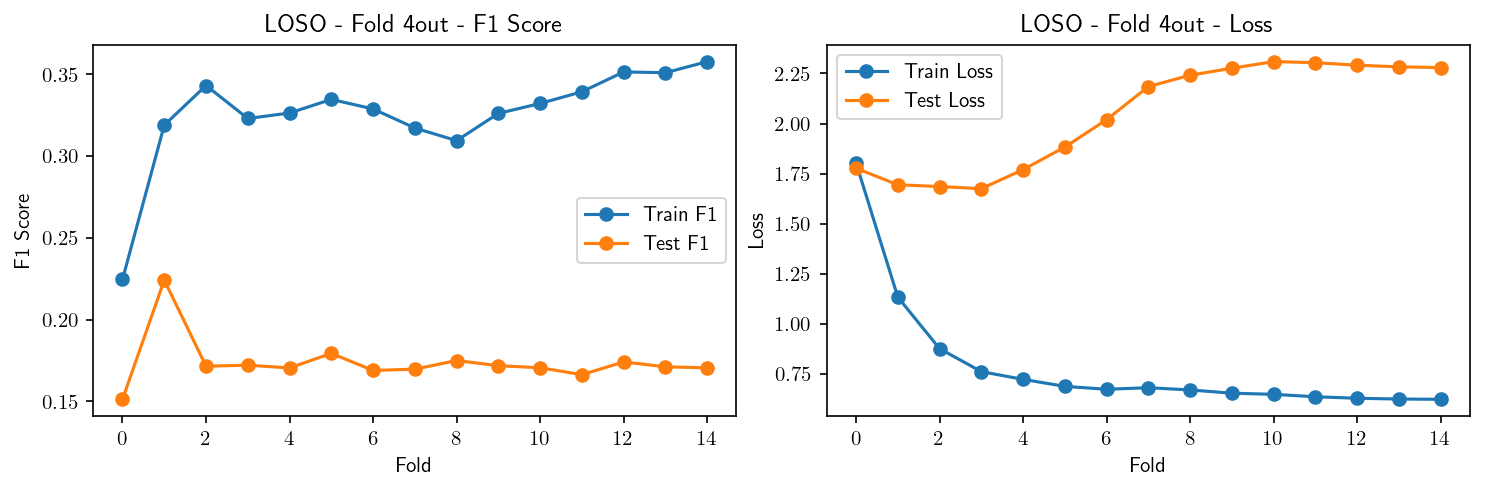

Loading data for LOSO with trial 5out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3605
Number of testing windows: 640
Class distribution for LOSO with trial 5out: [2.528050422668457, 4.595283508300781, 2.865659713745117, 17.802466074625652, 23.795377095540363, 14.835389455159506]
Class distribution for test set LOSO with trial 5out: [1.9335347414016724, 5.2032515207926435, 3.7209298610687256, 16.410250345865887, 26.666651407877605, 32.82048797607422]
Number of parameters to optimize: 1599590


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([885, 711, 646, 563, 428, 372]))
Epoch 1/15, F1: 0.2348,  Accuracy: 0.3556, Loss: 1.7193


Test: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


New best F1 score: 0.11809365212747225 at epoch 1, with binary F1: 0.6704288939051919.


100%|██████████| 8/8 [00:02<00:00,  3.53it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1375,  561, 1337,  166,   74,   92]))


Test: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


New best F1 score: 0.24448008676251784 at epoch 2, with binary F1: 0.6956521739130435.


100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1426,  249, 1863,   37,   16,   14]))


100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1432,  523, 1617,   18,    3,   12]))


100%|██████████| 8/8 [00:02<00:00,  3.54it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1427,  448, 1705,   10,    1,   14]))


100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1433,  290, 1872,    6,    4]))
Epoch 6/15, F1: 0.3230,  Accuracy: 0.7240, Loss: 0.7510


100%|██████████| 8/8 [00:02<00:00,  3.54it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1406,  378, 1811,    4,    1,    5]))


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1430,  510, 1657,    4,    4]))


100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1466,  406, 1727,    4,    2]))


100%|██████████| 8/8 [00:02<00:00,  3.51it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1423,  332, 1844,    3,    3]))


100%|██████████| 8/8 [00:02<00:00,  3.51it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 4, 5]), array([1412,  333, 1850,    6,    1,    3]))
Epoch 11/15, F1: 0.3328,  Accuracy: 0.7323, Loss: 0.6890


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1417,  378, 1806,    3,    1]))


100%|██████████| 8/8 [00:02<00:00,  3.54it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1420,  405, 1772,    4,    4]))


100%|██████████| 8/8 [00:02<00:00,  3.53it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1415,  419, 1762,    5,    4]))


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]


Unique labels in train_all_labels: (array([0, 1, 2, 3, 4, 5]), array([1426,  523, 1258,  135,  101,  162]))
Unique preds in train_all_preds: (array([0, 1, 2, 3, 5]), array([1418,  390, 1786,    5,    6]))
Epoch 15/15, F1: 0.3575,  Accuracy: 0.7487, Loss: 0.6516


Test: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


New best F1 score: 0.24926286217365012 at epoch 15, with binary F1: 0.7070422535211267.
Inference rate: 0.9160 ms per window.


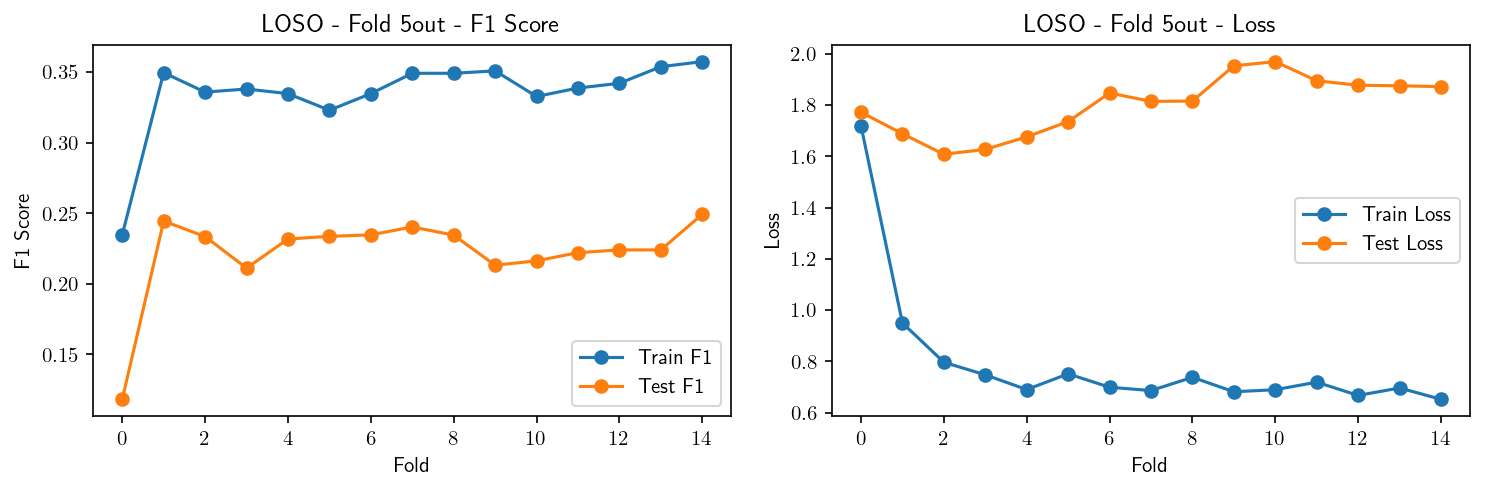

🏃 View run gregarious-wasp-901 at: http://127.0.0.1:8080/#/experiments/144067866410700569/runs/4864dcc6a0074c86aacba2bb8a4eec36
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/144067866410700569


In [3]:
mlflow.set_experiment(f"{exp_kwargs['model_name']}_{exp_kwargs['data_type']}_ES")

#Ensure seed is set for reproducibility
torch.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

samples_train, samples_test, inference_rates, train_times = [], [], [], []

with mlflow.start_run() as run:
    
    #Log the hyperparameters
    if not exp_kwargs['save_local']:
        mlflow.log_params(exp_kwargs)
        run_id = run.info.run_id

    for setting in settings:

        if setting == 'LOSO':
            outs = out2
        else:
            outs = out1

        for out in outs:

            #Delete device and RAM memory
            if cuda:
                torch.cuda.empty_cache()
            else:
                torch.mps.empty_cache()
                

            #Initialize lists to store results for each fold
            train_loss_fold, train_f1_binary_fold, train_f1_fold, train_accuracy_binary_fold, \
            train_acc_fold, train_jaccard_binary_fold, train_jaccard_fold, train_cm_binary_fold, train_cm_fold, \
            test_loss_fold, test_f1_binary_fold, test_f1_fold, test_accuracy_binary_fold, \
            test_acc_fold, test_jaccard_binary_fold, test_jaccard_fold, test_cm_binary_fold, test_cm_fold, \
            train_times_fold = ([] for _ in range(19))

            best_f1 = 0.0
            best_loss = float('inf')    
            save_best = False

            #a. Load training and testing data
            print(f"Loading data for {setting} with trial {out}...")
            fold_data_path = f"data/LOSO/{exp_kwargs['frequency']}Hz/" + out + '/'
            video_data_path = f"../Chain-of-Gesture/dataset/setting_f1/LOSO/All/{out}"
            #video_data_path = None
            
            #b. Retrieve dataloaders
            train_dataloader, test_dataloader = retrieve_dataloaders_window(fold_data_path=fold_data_path,
                                                                    video_data_path=video_data_path,
                                                                    exp_kwargs=exp_kwargs,
                                                                    window_size=window_size,
                                                                    stride=stride)
            
            samples_train.append(len(train_dataloader.dataset))
            samples_test.append(len(test_dataloader.dataset))
            
            #b.2. Compute class balance
            if not exp_kwargs['siamese']:
                class_counts = train_dataloader.dataset.specific_error_distribution
                class_counts_test = test_dataloader.dataset.specific_error_distribution
                #Counter extremely large reverse class frequencies
                class_counts[0], class_counts[2] = class_counts[0], class_counts[2]
                class_counts_test[0], class_counts_test[2] = class_counts_test[0], class_counts_test[2]
                class_counts[1], class_counts[3], class_counts[4], class_counts[5] = class_counts[1]/1.5, class_counts[3]/1.5, class_counts[4]/1.5, class_counts[5]/1.5
                class_counts_test[1], class_counts_test[3], class_counts_test[4], class_counts_test[5] = class_counts_test[1]/1.5, class_counts_test[3]/1.5, class_counts_test[4]/1.5, class_counts_test[5]/1.5
                print(f"Class distribution for {setting} with trial {out}: {class_counts}")
                print(f"Class distribution for test set {setting} with trial {out}: {class_counts_test}")

            #c. Define model objects
            feature_extractor, model, criterion, optimizer, scheduler = define_model_objects(exp_kwargs=exp_kwargs,
                                                                                             in_features_dict=in_features_dict,
                                                                                             window_size=window_size,
                                                                                             device=device,
                                                                                             class_counts=class_counts if not exp_kwargs['siamese'] else None)

            model_folder = f'models/{exp_kwargs["data_type"]}_error_specific/{exp_kwargs["frequency"]}Hz/{model.name}/'

            #d. Training loop
            for epoch in range(exp_kwargs['n_epochs']):
                train_start = time.time()
                
                train_average_loss, train_f1_binary, train_f1_macro, train_accuracy_binary, train_accuracy_macro,\
                train_jaccard_binary, train_jaccard_macro, train_cm_binary, train_cm_macro,\
                train_all_probs, train_all_preds, train_all_labels, train_all_labels_binary, train_all_preds_binary = train_single_epoch_ES(model=model, 
                                                            feature_extractor=feature_extractor,
                                                            train_dataloader=train_dataloader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs,
                                                            scheduler=scheduler)
                    
                train_end = time.time()
                train_times_fold.append(train_end - train_start)

                if epoch % 5 == 0 or epoch == exp_kwargs['n_epochs'] - 1:
                    print(f"Epoch {epoch + 1}/{exp_kwargs['n_epochs']}, F1: {train_f1_macro:.4f},  Accuracy: {train_accuracy_macro:.4f}, Loss: {train_average_loss:.4f}")

                #Append to vectors
                train_f1_fold.append(train_f1_macro)
                train_f1_binary_fold.append(train_f1_binary)
                train_acc_fold.append(train_accuracy_macro)
                train_accuracy_binary_fold.append(train_accuracy_binary)
                train_jaccard_fold.append(train_jaccard_macro)
                train_jaccard_binary_fold.append(train_jaccard_binary)
                train_loss_fold.append(train_average_loss)
                train_cm_fold.append(train_cm_macro.tolist())
                train_cm_binary_fold.append(train_cm_binary.tolist())

                #Validation loop
                test_average_loss, test_f1_binary, test_f1_macro, test_accuracy_binary, test_accuracy_macro, \
                test_jaccard_binary, test_jaccard_macro, test_cm_binary, test_cm_macro, inference_rate, \
                test_all_probs, test_all_preds, test_all_labels, test_all_labels_binary, test_all_preds_binary, \
                test_all_gest_labels, test_all_subjects = validate_single_epoch_ES(model=model,
                                                            feature_extractor=feature_extractor,
                                                            test_dataloader=test_dataloader,
                                                            criterion=criterion,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs)
                
                #Append to vectors
                test_f1_fold.append(test_f1_macro)
                test_f1_binary_fold.append(test_f1_binary)
                test_acc_fold.append(test_accuracy_macro)
                test_accuracy_binary_fold.append(test_accuracy_binary)      
                test_jaccard_fold.append(test_jaccard_macro)
                test_jaccard_binary_fold.append(test_jaccard_binary)
                test_loss_fold.append(test_average_loss)
                test_cm_fold.append(test_cm_macro.tolist())
                test_cm_binary_fold.append(test_cm_binary.tolist())

                if exp_kwargs['loss_or_f1'] == 'loss':
                    if test_average_loss < best_loss:
                        save_best = True
                        best_loss = test_average_loss
                        print(f"New best loss: {test_average_loss} at epoch {epoch + 1}")

                elif exp_kwargs['loss_or_f1'] == 'f1':
                    if test_f1_macro > best_f1:
                        save_best = True
                        best_f1 = test_f1_macro
                        print(f"New best F1 score: {test_f1_macro} at epoch {epoch + 1}, with binary F1: {test_f1_binary}.")

                if save_best:
                    
                    best_model = {
                        'feature_extractor': feature_extractor,
                        'model': model,
                        'epoch': epoch + 1,
                        'train_f1_binary_fold': train_f1_binary,
                        'train_f1_fold': train_f1_macro,
                        'train_accuracy_binary_fold': train_accuracy_binary,
                        'train_acc_fold': train_accuracy_macro,
                        'train_jaccard_binary_fold': train_jaccard_binary,
                        'train_jaccard_fold': train_jaccard_macro,
                        'train_cm_binary_fold': train_cm_binary.tolist(),
                        'train_cm_fold': train_cm_macro.tolist(),
                        'test_f1_binary_fold': test_f1_binary,
                        'test_f1_fold': test_f1_macro,
                        'test_accuracy_binary_fold': test_accuracy_binary,
                        'test_acc_fold': test_accuracy_macro,
                        'test_jaccard_binary_fold': test_jaccard_binary,
                        'test_jaccard_fold': test_jaccard_macro,
                        'test_cm_binary_fold': test_cm_binary.tolist(),
                        'test_cm_fold': test_cm_macro.tolist(),
                        'train_loss_fold': train_average_loss,
                        'test_loss_fold': test_average_loss, 
                        'test_all_preds': test_all_preds,
                        'test_all_preds_binary': test_all_preds_binary,
                        'test_all_probs': test_all_probs,
                        'test_all_labels': test_all_labels,
                        'test_all_labels_binary': test_all_labels_binary,
                        'test_all_gest_labels': test_all_gest_labels,
                        'test_all_subjects': test_all_subjects,
                    }

                    save_best = False  #Reset save_best to False after saving the best model
                
                if not exp_kwargs['save_local']:
                    #Log metrics to mlflow
                    mlflow.log_metric(f'train_loss_fold_{out}', train_average_loss, step=epoch)
                    mlflow.log_metric(f'test_loss_fold_{out}', test_average_loss, step=epoch)
                    mlflow.log_metric(f'train_f1_fold_{out}', train_f1_macro, step=epoch)
                    mlflow.log_metric(f'test_f1_fold_{out}', test_f1_macro, step=epoch)
                    mlflow.log_metric(f'train_acc_fold_{out}', train_accuracy_macro, step=epoch)
                    mlflow.log_metric(f'test_acc_fold_{out}', test_accuracy_macro, step=epoch)
                    mlflow.log_metric(f'train_jaccard_fold_{out}', train_jaccard_macro, step=epoch)
                    mlflow.log_metric(f'test_jaccard_fold_{out}', test_jaccard_macro, step=epoch)
                    
            #Display results for fold
            print(f"Inference rate: {inference_rate:.4f} ms per window.")
            plot_results_LOSO(train_f1_fold=train_f1_fold,
                            test_f1_fold=test_f1_fold,
                            train_loss_fold=train_loss_fold,
                            test_loss_fold=test_loss_fold,
                            setting=setting, out=out,
                            image_folder=image_folder)
            
        
            #Save best model
            if exp_kwargs['save_local']:
                pass   
                        
            else:
                #Log model to mlflow
                #if exp_kwargs['data_type'] != 'kinematics':
                    
                    #mlflow.pytorch.log_model(pytorch_model=best_model['feature_extractor'], 
                        #                    name=f'feature_extractor_{setting}_{out}')
                                
                #mlflow.pytorch.log_model(pytorch_model=best_model['model'], 
                      #                  name=f'model_{setting}_{out}')        
                      # 

                #Save model locally because mlflow gives errors
                if exp_kwargs['data_type'] != 'kinematics':
                    best_model['feature_extractor'] = best_model['feature_extractor'].state_dict()  
                    best_model['model'] = best_model['model'].state_dict()

                else:
                    best_model['feature_extractor'] = None
                    best_model['model'] = best_model['model'].state_dict()
                
                if not os.path.exists(model_folder):    
                    os.makedirs(model_folder)

                #model_path = os.path.join(model_folder, f'best_model_{setting}_{out}.pt')   
                #save_model(best_model=best_model, model_path=model_path)              
                #Log best_model rest of the dictionary without the state dicts
                best_model_dict = best_model.copy()
                best_model_dict.pop('feature_extractor', None)
                best_model_dict.pop('model', None)
                mlflow.log_dict(best_model_dict, f'best_model_{setting}_{out}.json')

            #Compute mean inference rate and train time; append to lists
            inference_rates.append(inference_rate)
            train_times.append(sum(train_times_fold) / len(train_times_fold))

            #Delete memory and variables
            del train_dataloader, test_dataloader, feature_extractor, model, best_model
            gc.collect()

mlflow.end_run()

Binary Summary DataFrame:


,F1,Accuracy,Jaccard,Train Time,Inference Rate
Train,0.973 ± 0.021,0.968 ± 0.025,0.948 ± 0.039,2.20 ± 0.06,NaN
Test,0.651 ± 0.093,0.624 ± 0.063,0.490 ± 0.102,NaN,0.93 ± 0.04


Confusion Matrix for Train:


<Figure size 2250x2250 with 0 Axes>

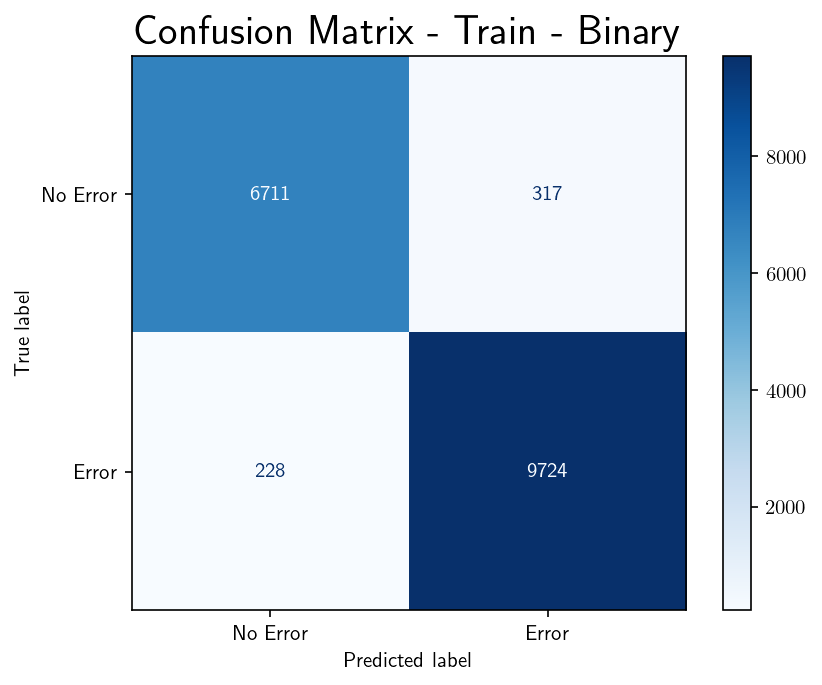

Confusion Matrix for Test:


<Figure size 2250x2250 with 0 Axes>

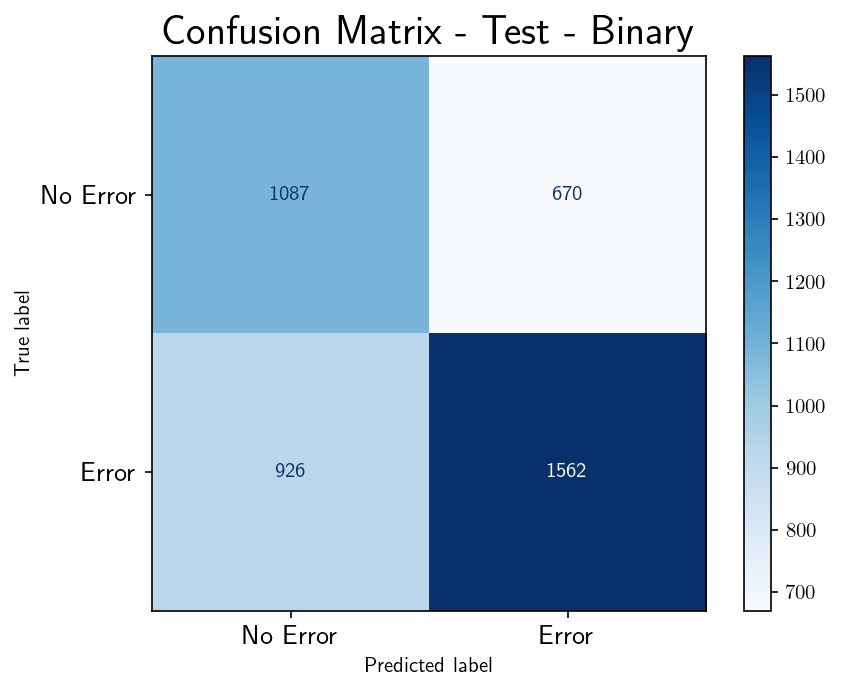

Error Specific Summary DataFrame:


,F1,Accuracy,Jaccard,Train Time,Inference Rate
Train,0.336 ± 0.017,0.691 ± 0.063,0.275 ± 0.022,2.20 ± 0.06,NaN
Test,0.214 ± 0.022,0.425 ± 0.029,0.138 ± 0.016,NaN,0.93 ± 0.04


Confusion Matrix for Train:
Confusion Matrix for Train:


<Figure size 2250x2250 with 0 Axes>

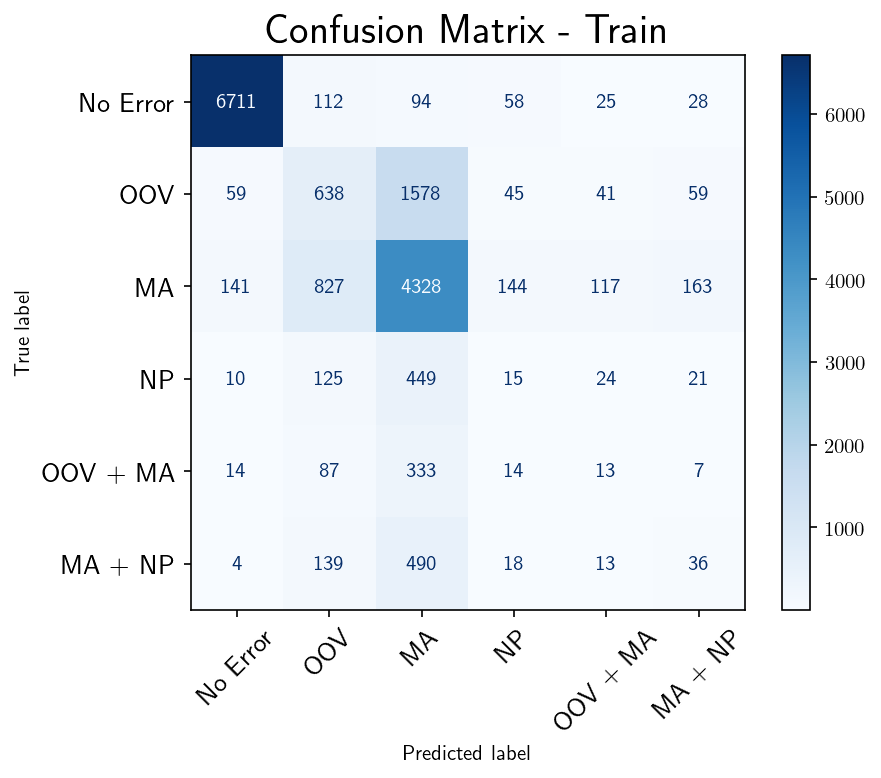

Confusion Matrix for Test:


<Figure size 2250x2250 with 0 Axes>

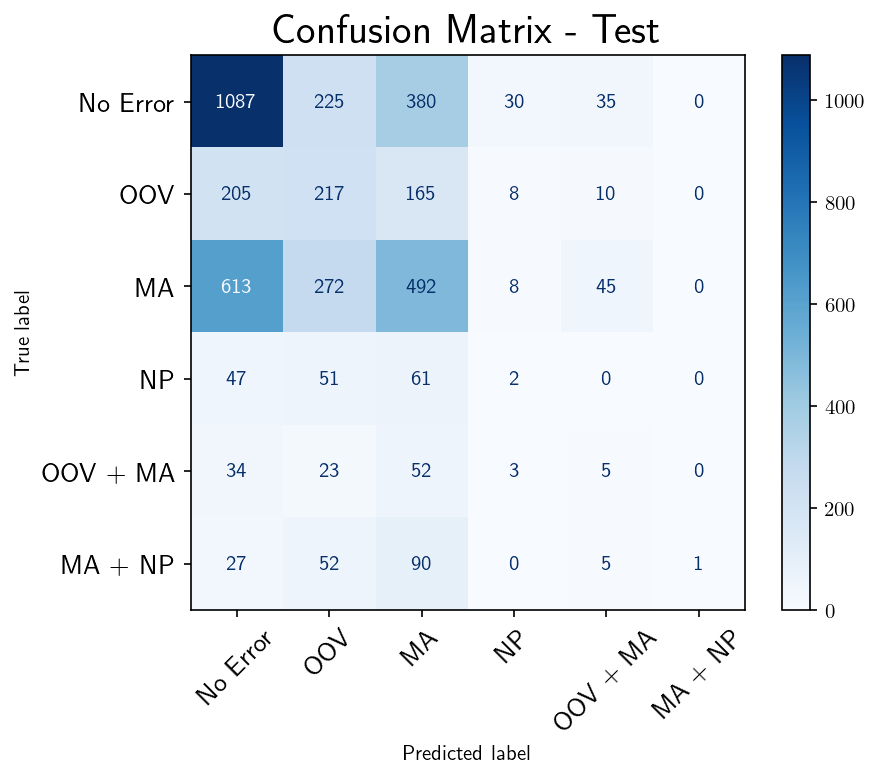

In [4]:
LOSO_f1_train, LOSO_f1_train_binary, LOSO_f1_test, LOSO_f1_test_binary, LOSO_acc_train, LOSO_acc_train_binary, LOSO_acc_test, LOSO_acc_test_binary, \
LOSO_jaccard_train, LOSO_jaccard_train_binary, LOSO_jaccard_test, LOSO_jaccard_test_binary, LOSO_cm_train, LOSO_cm_train_binary,\
LOSO_cm_test, LOSO_cm_test_binary, test_all_preds, test_all_preds_binary, test_all_probs, test_all_labels, test_all_labels_binary,\
                test_all_gest_labels, test_all_subjects = retrieve_results_mlflow_ES(outs=outs,
                                                                                    exp_kwargs=exp_kwargs,
                                                                                    setting=setting,
                                                                                    run_id=run_id)

#Compute binary metrics
summary_df_binary = create_summary_df(LOSO_f1_train=LOSO_f1_train_binary, LOSO_f1_test=LOSO_f1_test_binary, LOSO_acc_train=LOSO_acc_train_binary,
                                LOSO_acc_test=LOSO_acc_test_binary, LOSO_jaccard_train=LOSO_jaccard_train_binary, LOSO_jaccard_test=LOSO_jaccard_test_binary,
                                samples_train=samples_train, samples_test=samples_test,inference_rates=inference_rates, train_times=train_times)


#Save binary summary df to csv
print("Binary Summary DataFrame:")
display(summary_df_binary)
summary_df_binary.to_csv(os.path.join(results_folder, 'LOSO_summary_df_binary.csv'), index=False)

#Compute binary cm
plot_cm(LOSO_cm_train = LOSO_cm_train_binary, LOSO_cm_test= LOSO_cm_test_binary, image_folder=image_folder, binary = "Binary")

#Compute error specific metrics
summary_df_specific = create_summary_df(LOSO_f1_train=LOSO_f1_train, LOSO_f1_test=LOSO_f1_test, LOSO_acc_train=LOSO_acc_train,
                                    LOSO_acc_test=LOSO_acc_test, LOSO_jaccard_train=LOSO_jaccard_train, LOSO_jaccard_test=LOSO_jaccard_test,
                                    samples_train=samples_train, samples_test=samples_test,inference_rates=inference_rates, train_times=train_times)

#Save summary df to csv
print("Error Specific Summary DataFrame:")
display(summary_df_specific)
summary_df_specific.to_csv(os.path.join(results_folder, 'LOSO_summary_df.csv'), index=False)

print("Confusion Matrix for Train:")
plot_cm(LOSO_cm_train = LOSO_cm_train, LOSO_cm_test= LOSO_cm_test, image_folder=image_folder)